In [36]:
import os
import codecs
import time
import yaml

import rqalpha as rqa
import rqalpha_plus
import rqdatac as rqd
import rqoptimizer as rqo

import pandas as pd
import numpy as np

import utils

%matplotlib inline

In [37]:
def _init_rqdata(conf_path):
    with codecs.open(conf_path, 'r', encoding='utf8') as stream:
        conf = yaml.load(stream)
        if 'proxy' in conf:
            proxy_info = (conf['proxy'].get('type'),
                conf['proxy'].get('host'),
                conf['proxy'].get('port'),
                conf['proxy'].get('user'),
                conf['proxy'].get('password'))
        else:
            proxy_info = None
        rqd.init(conf['rqdata_username'], conf['rqdata_password'],
            (conf['rqdata_host'], conf['rqdata_port']), proxy_info=proxy_info)

# backtest related
def get_target_stocks(universe_symbol, date, factor, percent_selected, min_selected):
    selection_date = rqd.get_previous_trading_date(date)
    universe = rqd.index_components(universe_symbol, selection_date)
    universe = utils.drop_suspended(universe, selection_date)
    universe = utils.drop_ST(universe, selection_date)
    universe = utils.drop_recently_listed(universe, selection_date, 60)
    
    scores = rqd.get_factor(universe, factor, selection_date, selection_date)
    return utils.select_top_N_percent(
        universe, selection_date, scores, percent_selected, min_selected,
        grouper=utils.get_industry, 
    )

def get_target_portfolio(universe, date, **optimization_args):
    # rqoptimizer 默认取date前一个交易日的数据
    target_portfolio = rqo.portfolio_optimize(
        universe, date, **optimization_args
    )
    return target_portfolio.loc[lambda x: x != 0]
    

def _should_rebalance(context):
    prev_trading_day = rqd.get_previous_trading_date(context.now)
    is_month_start = (prev_trading_day.month != context.now.month)
    return is_month_start

def rebalance(context, target_portfolio, bar_dict):
    # 先清空不在目标组合里面的股票
    positions = context.stock_account.positions
    for order_book_id in positions:
        if order_book_id not in target_portfolio:
            rqa.api.order_to(order_book_id, 0)
            
    # 对每个股票计算目标权重和当前权重的差值
    # 差值为正的是买单, 反之为卖单
    capital = context.stock_account.total_value * (1 - context.cash_cushion)
    to_sell, to_buy = {}, {}
    for order_book_id, weight in target_portfolio.items():
        target_value = capital * weight
        gap = target_value - positions[order_book_id].market_value
        if gap > 0:
            to_buy[order_book_id] = gap
        else:
            to_sell[order_book_id] = gap

    # to avoid liquidity issue, sell first, buy second
    _money_for_one_lot = lambda order_book_id: bar_dict[order_book_id].close * 100
    for order_book_id, value in to_sell.items():
        if abs(value) > _money_for_one_lot(order_book_id):
            rqa.api.order_value(order_book_id, value)

    for order_book_id, value in to_buy.items():
        if abs(value) > _money_for_one_lot(order_book_id):
            rqa.api.order_value(order_book_id, value)
            
            
def handle_bar(context, bar_dict):
    if not _should_rebalance(context):
        return
    target_stocks = get_target_stocks(context.benchmark_symbol, context.now, **context.stock_selection_args)
    target_portfolio = get_target_portfolio(target_stocks, context.now, **context.optimization_args)
    rebalance(context, target_portfolio, bar_dict)
    
    
def init(context):
    _init_rqdata('rqpro.yml')

# performance analysis

def cumulative_excess_return(backtest_result):
    strat_portf = backtest_result['sys_analyser']['portfolio']
    benchmark_portf = backtest_result['sys_analyser']['benchmark_portfolio']
    
    strat_return = strat_portf['unit_net_value'].pct_change()
    benchmark_return = benchmark_portf['unit_net_value'].pct_change()
    
    excess_return = strat_return - benchmark_return
    
    return (excess_return).cumsum()+1
    

def average_turnover(backtest_result):
    sell_trades = backtest_result['sys_analyser']['trades'].query("side == 'SELL'")
    portfolio = backtest_result['sys_analyser']['portfolio']
    
    total_trade_value = lambda df: (df['last_price'] * df['last_quantity']).sum()
    value_sold = sell_trades.groupby(sell_trades.index, group_keys=False).apply(total_trade_value)
    value_sold.index = pd.to_datetime(value_sold.index).date
    
    capital = portfolio.loc[value_sold.index, 'total_value']
    
    return (value_sold / capital).mean()

def stock_position_stats(backtest_result):
    market_value = backtest_result['sys_analyser']['stock_account']['market_value']
    total_value = backtest_result['sys_analyser']['stock_account']['total_value']
    percentage = market_value / total_value
    num_holdings = backtest_result['sys_analyser']['stock_positions'].groupby(level='date').size()
    return pd.DataFrame(
        {'market_value': market_value, 
         'total_value': total_value,
         'percentage': percentage,
         'num_holdings': num_holdings,
        })

In [38]:
MILLION = 1_000_000
BILLION = 1000 * MILLION

config = {
    "base": {
        "matching_type": "current_bar",
        "start_date": '2020-01-01', 
        "end_date": '2020-06-30',
        "frequency": '1d',
        "accounts": {"stock": 0.1 * BILLION},
            },
    
    "mod": {
        "sys_analyser": {
            "enabled": True, "plot": True,  "benchmark": "000905.XSHG",
           },
    },
    
    "extra": {
        "log_level": 'error',
        "context_vars": {
            'cash_cushion': 0.005,
            'benchmark_symbol': '000905.XSHG',
            
            'stock_selection_args': {
                'factor': 'private.Hacken_Dividend',
                'percent_selected': 0.2,
                'min_selected': 2,
            },
            
            'optimization_args': {
                'benchmark': '000905.XSHG',
                'objective': rqo.MinTrackingError(),
                'cons': [rqo.WildcardIndustryConstraint(lower_limit=-0.03, upper_limit=0.03, relative=True)]
            },
        },
    },
}


In [39]:
backtest_result = rqa.run_func(handle_bar=handle_bar, init=init, config=config)

D:\Miniconda3\envs\machine_learning\lib\site-packages\rqoptimizer2\__init__.py:10: UserWarning: rqoptimizer2 即将废弃，建议使用 rqoptimizer
  warnings.warn('rqoptimizer2 即将废弃，建议使用 rqoptimizer')
D:\Miniconda3\envs\machine_learning\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
[2020-01-02 15:00:00.000000] ERROR: user_system_log: 策略运行产生异常
Traceback (most recent call last):
  File "D:\Miniconda3\envs\machine_learning\lib\site-packages\rqalpha\core\strategy.py", line 97, in handle_bar
    self._handle_bar(self._user_context, bar_dict)
  File "<ipython-input-37-c25f4b477961>", line 73, in handle_bar
    if not _should_rebalance(context):
  File "<ipython-input-37-c25f4b477961>", line 38, in _should_rebalance
    prev_trading_day = rqd.get_previous_trading_date(context.now)
  File "D:\Miniconda3\envs\machine_learning\lib\site-packages\rqdatac\decorators.py"

[2020-06-30 15:30:00.000000] INFO: user_log: Average Turnover: 0.19135577287539499


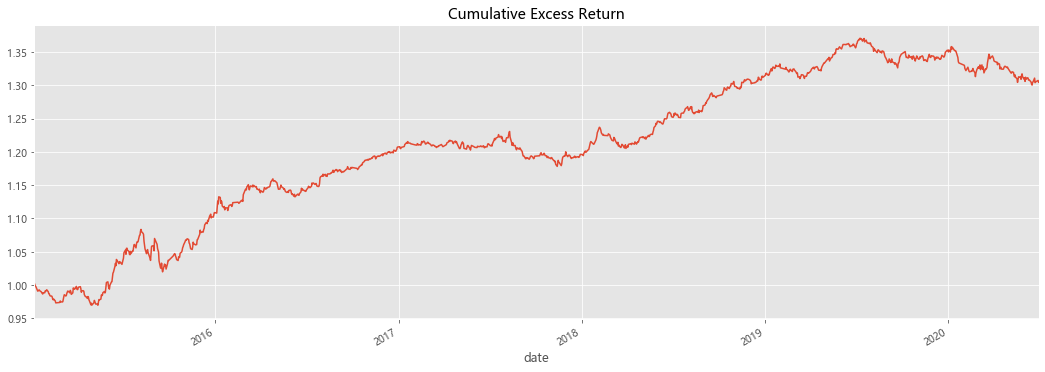

In [11]:
cumulative_excess_return(backtest_result).plot(title='Cumulative Excess Return', figsize=(18, 6))
print(f'Average Turnover: {average_turnover(backtest_result)}')

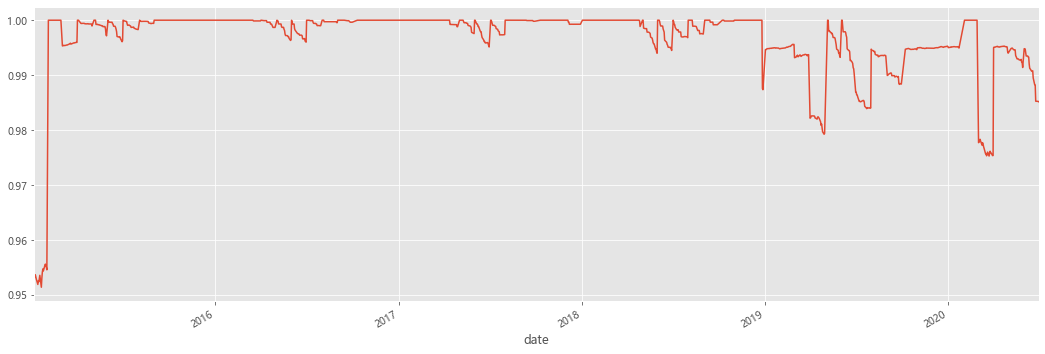

In [12]:
stock_position_stats(backtest_result)['percentage'].plot(figsize=(18, 6))

In [ ]:
_RICEQUANT_FACTORS = rqd.get_all_factors()

_CACHE = {} # factor -> pd.Series
def _get_factor_from_local_file(order_book_ids, factor, start_date, end_date):
    if factor in _CACHE:
        return _CACHE[factor].loc[order_book_ids, ...]
    else:
        data = pickle.load(path_to_factor_files)
        _CACHE[factor] = data
        return data.loc[order_book_ids, ...]
        
    
    
def get_factor(order_book_ids, factor, start_date, end_date):
    if factor in _RICEQUANT_FACTORS:
        return rqd.get_factor(order_book_ids, factor, start_date, end_date)
    elif factor in _LOCAL_FACTORS:
        return _get_factor_from_local_file(factor)

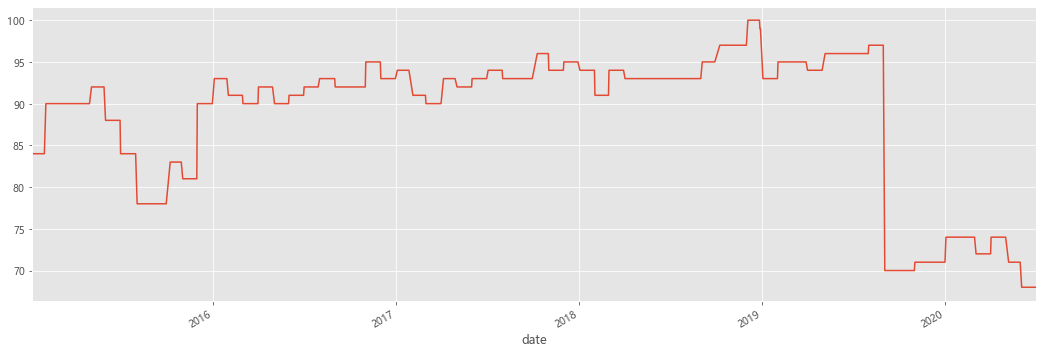

In [13]:
stock_position_stats(backtest_result)['num_holdings'].plot(figsize=(18, 6))